# DUD-E enrichment

## preparation

In [1]:
import os, sys, itertools, glob, re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

In [2]:
possible_models = {'esvr': 'Epsilon-Support Vector Regression',
                   'erf': 'Extremely Random Forest',
                   'lr': 'LinearRegression',
                   'knn': 'Nearest-Neighbor',
                   'dnn': 'RASPDeep',
                   'rf': 'Random Forest',
                   'svr': 'Support Vector Regression'}
modelstr = " ".join(possible_models)
modelstr

'esvr erf lr knn dnn rf svr'

In [3]:
n_repls = 1 
n_cores = 8

weight_dir = "../../../weights/" 


work_path = "../enrich_results"
os.makedirs(work_path, exist_ok=True)


dud_path = "../../../dude"

raspd_path = "../../../dude_raspd_old"


In [4]:
with open(dud_path + "/list") as f:
    dud_names = [name.strip() for name in f.readlines()]
len(dud_names)

102

In [5]:
with open(dud_path + "/list_excluded_pockets") as f:
    exclusion_names = [name.strip() for name in f.readlines()]
len(exclusion_names)

47

In [6]:
special_groups = {
    "list_cyp": "Cytochrome P450",
     "list_gpcr": "GPCR",
     "list_ionchannel" : "Ion channel",
     "list_kinases": "Kinase", 
     "list_metalloenzyme": "Metal containing enzyme",
    "list_nuclear": "Nuclear receptor",
    "list_protease": "Protease",
        "list_miscellaneous": "Miscellaneous", 

}

special_lists ={}

for grp_name in special_groups.keys():
    with open(dud_path + "/" + grp_name) as f:
        special_lists[grp_name] = [name.strip() for name in f.readlines()]


special_map = {val: k for k, vals in special_lists.items() for val in vals}

In [7]:
# Sanity checks

In [8]:
len(special_map)

102

In [9]:
len(set(itertools.chain.from_iterable(special_lists.values())))

102

In [10]:
set(itertools.chain.from_iterable(special_lists.values())).symmetric_difference(dud_names)

set()

In [11]:
parameter_files = {}

subdirs = {}
for name in dud_names:
    
    parameter_file = "{}/{}_PARAMETERS_MILLION.txt".format(dud_path, name)
    parameter_files[name] = parameter_file 
    assert os.path.exists(parameter_file)
    
    subdirs[name] = {}
    for i in range(n_repls):
        tmp_out = os.path.join(work_path, name, str(i))
        subdirs[name][i] = tmp_out
        os.makedirs(tmp_out, exist_ok=True)
        
        ## Comment out to run the inference (keep commented to run nb without)
        #os.system(f"python ../infer.py -d {tmp_out} -w {weight_dir} -i {parameter_file} -m {modelstr} -s {i} -c {n_cores}")


In [12]:
raspd_old_results = {name: os.path.join(raspd_path, "{}_raspd.be".format(name)) for name in dud_names}

In [13]:
def compute_ef_single(df, fractions=[0.01, 0.05, 0.1], ascending=True):
    actives = df['active'].sum()
    decoys = (~df['active']).sum()
    total = df.shape[0]
    assert total == actives + decoys
    efs = {}
    for frac in fractions:
        portion = int(total * frac)
        recovered = df.sort_values('value', ascending=ascending).iloc[:portion]['active'].sum()
        ef = (recovered / portion) / (actives / total)
        efs[str(frac)] = ef
    return {"actives": actives, "decoys": decoys, **efs}

In [14]:
def compute_ef_union(dfs, fractions=[0.01, 0.05, 0.1], ascending=True, active_str="AC_"):
    dfs = [df.sort_values('value', ascending=ascending) for df in dfs]
    actives = dfs[0]['active'].sum()
    decoys = (~dfs[0]['active']).sum()
    total = dfs[0].shape[0]
    assert total == actives + decoys
    efs = {}
    for frac in fractions:
        portion = int(total * frac)
        recover = set()
        for cands in zip(*[df['id'] for df in dfs]):
            if len(recover.union(cands)) > portion:
                break
            recover.update(cands)
        assert len(recover) <= portion
        assert portion - len(recover) < 7
        uniqued = pd.Series(list(recover))
        recovery_rate = uniqued.str.match(active_str).mean()
        efs[str(frac)] = recovery_rate / (actives / total)
    return efs

In [15]:
def mean_result_df(dfs):
    id_frame = dfs[0][['id', 'active']]
    mean_value = pd.concat([df['value'] for df in dfs], axis=1).mean(axis=1)
    mean_value = pd.Series(mean_value, name='value')
    return id_frame.join(mean_value)

In [16]:
def compute_ef_table(output_list):
    res = {}
    efs = {}
    for name in dud_names:
        res[name] = {}
        efs[name] = {}
        ids = pd.read_csv(parameter_files[name], sep=";", usecols=["PDBID"])["PDBID"].rename('id')
        for repl in range(n_repls):
            res[name][repl] = {}
            efs[name][repl] = {}
            for model in possible_models:
                res_file = os.path.join(output_list[name][repl], f"{model}.out")
                df = (pd.read_csv(res_file, delim_whitespace=True, header=None, names=['value', 'std'])
                        .drop(columns=['std']))
                assert df.shape[0] == ids.shape[0]
                dat = df.join(ids)
                dat['active'] = dat['id'].str.match('AC_')
                dat = dat.sort_values('value', ascending=True)
                
                res[name][repl][model] = dat
                efs[name][repl][model] = compute_ef_single(dat)
            # Add RASPD old    
            dat = pd.read_csv(raspd_old_results[name], delim_whitespace=True, header=None, names=['id', 'value'])
            pd.testing.assert_series_equal(ids, dat["id"])
        
            dat['active'] = dat['id'].str.match('AC_')
            dat = dat.sort_values('value', ascending=True)
            
            res[name][repl]['RASPD'] = dat
            efs[name][repl]['RASPD'] = compute_ef_single(dat)
            # merge and compute
            efs[name][repl] = pd.DataFrame.from_records(efs[name][repl])

            mean_ensemble = compute_ef_single(mean_result_df([val for key, val in res[name][repl].items() if key not in ['RASPD']]))
            mean_ens_dknn = compute_ef_single(mean_result_df([val for key, val in res[name][repl].items() if key not in ['RASPD', "knn"]]))
            union = compute_ef_union([val for key, val in res[name][repl].items() if key not in ['RASPD']])
            union_dknn = compute_ef_union(val for key, val in res[name][repl].items() if key not in ['RASPD', "knn"])
            union_lin_svr = compute_ef_union(val for key, val in res[name][repl].items() if key in ['esvr', 'lr', 'svr'])
            
            efs[name][repl] = efs[name][repl].join(
                pd.DataFrame({'mean_ensemble': pd.Series(mean_ensemble),
                              'mean_ens_dknn': pd.Series(mean_ens_dknn),
                              'union': pd.Series(union),
                              'union_dknn': pd.Series(union_dknn),
                              'union_lin_svr': pd.Series(union_lin_svr),
                             }))
        efs[name] = pd.concat(efs[name], names=['replicate'])


    efs = pd.concat(efs, names=['system'])
    return efs, res

In [17]:
enrichments, details = compute_ef_table(subdirs)


In [18]:
value_order = ['erf', 'rf', 'dnn', 'knn', 'svr', 'esvr', 'lr', 
               'mean_ensemble','union', 'union_dknn', 'union_lin_svr', 'RASPD']

enrichments = enrichments[value_order]

enrichments.index.rename('level', level=2, inplace=True)
enrichments.columns.rename('method', inplace=True)


In [19]:
def texify_val_error(values, nan_text="NA", sig_digits=2, force_sig=False):
    nan_check = pd.isna(values)
    if nan_check[0]:
        return nan_text
    elif nan_check[1] or values[1] == 0:
        return "{{:.{}f}}".format(sig_digits).format(values[0])
    else:
        error = "{:.2g}".format(values[1])
        split_error = error.split(".")
        if len(split_error) == 2:
            sig = len(split_error[1])
            if force_sig:
                sig = min(sig, sig_digits)
            value = '{{:.{prec}f}}'.format(prec=sig).format(values[0])
            error = '{{:.{prec}f}}'.format(prec=sig).format(values[1])
        else:
            error = str(round(values[1]))
            value = str(round(values[0]))
        return "\\num{{{} \\pm {}}}".format(value, error)


def texify_df_groupby(df, axis=1, stats=('mean', 'std'), force_sig=False):
    trans_func=None
    if force_sig:
        trans_func = functools.partial(texify_val_error, force_sig=True)
    else:
        trans_func = texify_val_error
    result = (df.agg([*stats])
         .groupby(axis=axis, level=0).transform(trans_func)
         .xs("mean", axis=axis, level=1)
         )
    return result

# Overview figure 1% enrichment

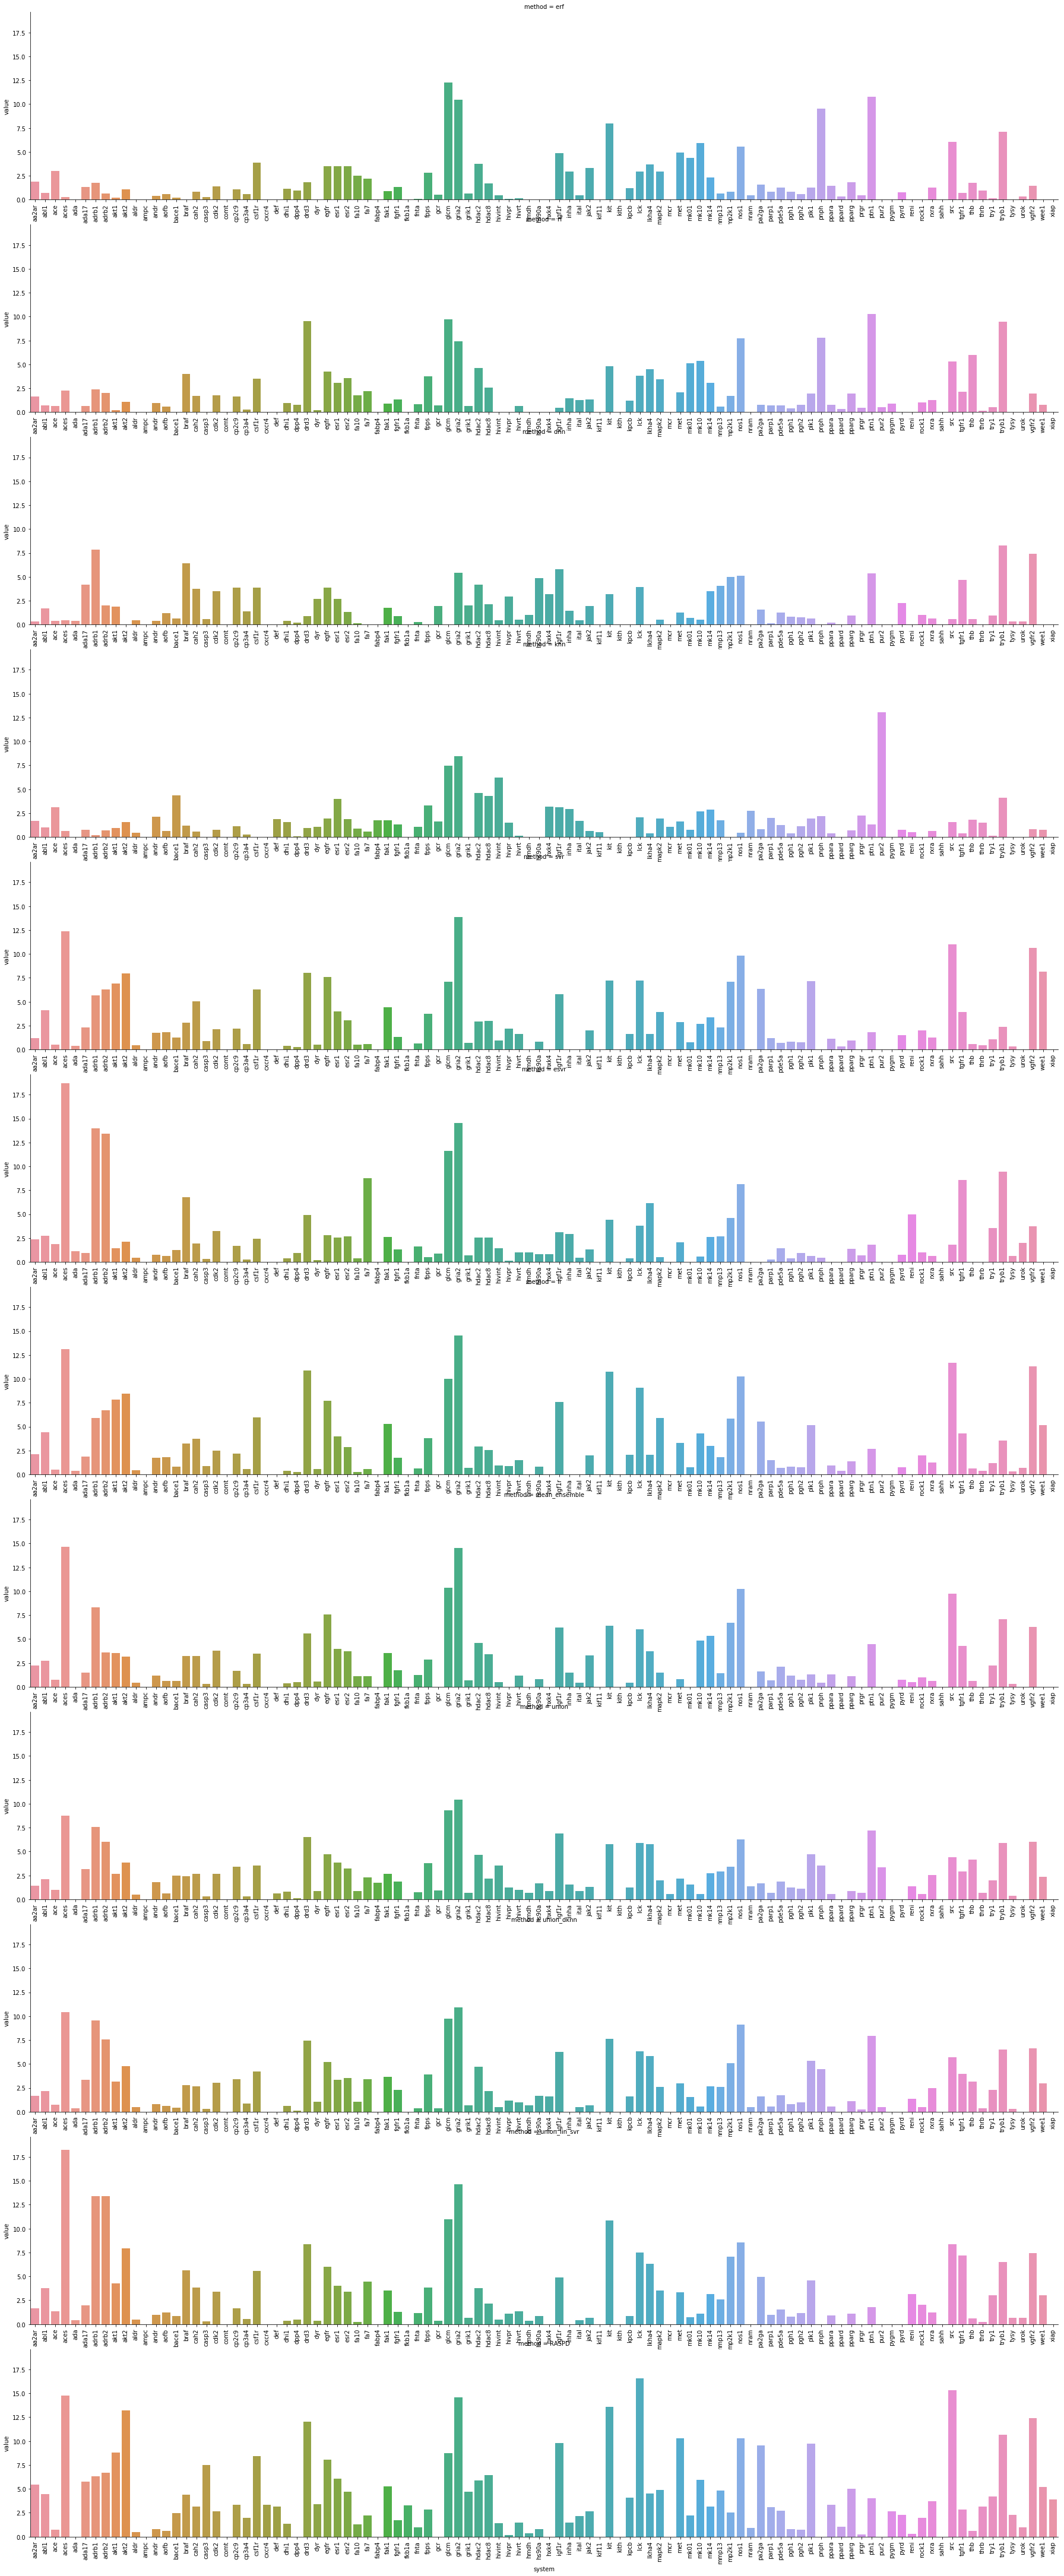

In [20]:
g = sns.catplot(data=enrichments.stack().rename('value').xs("0.01", level="level").reset_index(), kind='bar', x='system', y="value", col="method", col_wrap=1, aspect=5, sharex=False)
g.set_xticklabels(rotation=90)


# Results

In [21]:
enrichments.stack().groupby(level=['level', 'method']).agg(['mean', 'std']).unstack().T

level                   0.01      0.05       0.1     actives        decoys
     method                                                               
mean erf            1.776197  1.520414  1.317791  396.490196  13868.813725
     rf             1.860837  1.526930  1.343555  396.490196  13868.813725
     dnn            1.620120  1.389520  1.279942  396.490196  13868.813725
     knn            1.480053  1.343209  1.230028  396.490196  13868.813725
     svr            2.584095  1.871992  1.620882  396.490196  13868.813725
     esvr           2.302081  1.574991  1.367459  396.490196  13868.813725
     lr             2.749839  1.977659  1.665252  396.490196  13868.813725
     mean_ensemble  2.317256  1.818877  1.556814  396.490196  13868.813725
     union          2.374044  1.818376  1.583583         NaN           NaN
     union_dknn     2.477226  1.827582  1.570041         NaN           NaN
     union_lin_svr  2.830763  1.941589  1.630840         NaN           NaN
     RASPD          4.101954  2.248785  1.730691  396.490196  13868.813725
std  erf            2.500221  1.373628  0.944782  306.338444  10815.847085
     rf             2.420776  1.492408  0.983850  306.338444  10815.847085
     dnn            1.992074  1.170485  0.869720  306.338444  10815.847085
     knn            1.931480  1.312165  0.876799  306.338444  10815.847085
     svr            3.137788  1.572663  1.148859  306.338444  10815.847085
     esvr           3.469504  1.529612  0.964180  306.338444  10815.847085
     lr             3.429736  1.722909  1.199841  306.338444  10815.847085
     mean_ensemble  3.042869  1.629992  1.081110  306.338444  10815.847085
     union          2.298009  1.396919  0.994307         NaN           NaN
     union_dknn     2.719129  1.494285  1.039085         NaN           NaN
     union_lin_svr  3.635808  1.746132  1.152669         NaN           NaN
     RASPD          4.045339  1.662133  1.114341  306.338444  10815.847085

In [22]:
enrichments

method                             erf            rf           dnn  \
system replicate level                                               
aa2ar  0         0.01         1.896138      1.659121      0.355526   
                 0.05         2.986417      2.346471      0.971771   
                 0.1          2.417576      2.239813      0.948069   
                 actives    844.000000    844.000000    844.000000   
                 decoys   32063.000000  32063.000000  32063.000000   
abl1   0         0.01         0.682852      0.682852      1.707131   
                 0.05         0.881356      0.474576      1.423729   
                 0.1          0.813559      0.508475      1.186441   
                 actives    295.000000    295.000000    295.000000   
                 decoys   10885.000000  10885.000000  10885.000000   
ace    0         0.01         2.996640      0.624300      0.374580   
                 0.05         2.441799      0.298996      1.220900   
                 0.1          1.906098      0.710115      1.357939   
                 actives    803.000000    803.000000    803.000000   
                 decoys   17144.000000  17144.000000  17144.000000   
aces   0         0.01         0.301618      2.262132      0.452426   
                 0.05         0.361673      1.627529      1.838505   
                 0.1          0.316347      1.159939      1.988467   
                 actives    664.000000    664.000000    664.000000   
                 decoys   26373.000000  26373.000000  26373.000000   
ada    0         0.01         0.000000      0.000000      0.383956   
                 0.05         0.153045      0.229568      0.306091   
                 0.1          0.343751      0.305557      0.496530   
                 actives    262.000000    262.000000    262.000000   
                 decoys    5472.000000   5472.000000   5472.000000   
ada17  0         0.01         1.355759      0.625735      4.171566   
                 0.05         1.501764      1.126323      2.127499   
                 0.1          1.355759      1.147181      1.512193   
                 actives    959.000000    959.000000    959.000000   
                 decoys   36646.000000  36646.000000  36646.000000   
...                                ...           ...           ...   
tryb1  0         0.01         7.093117      9.457490      8.275304   
                 0.05         3.276516      4.095645      4.914774   
                 0.1          2.574406      2.574406      4.037136   
                 actives    171.000000    171.000000    171.000000   
                 decoys    7713.000000   7713.000000   7713.000000   
tysy   0         0.01         0.000000      0.000000      0.325800   
                 0.05         0.322170      0.128868      0.644341   
                 0.1          0.386067      0.418239      0.482583   
                 actives    311.000000    311.000000    311.000000   
                 decoys    6883.000000   6883.000000   6883.000000   
urok   0         0.01         0.328047      0.000000      0.328047   
                 0.05         0.851253      0.720291      1.571544   
                 0.1          1.341048      1.308340      1.602716   
                 actives    306.000000    306.000000    306.000000   
                 decoys    9933.000000   9933.000000   9933.000000   
vgfr2  0         0.01         1.451613      1.935484      7.419355   
                 0.05         1.354839      2.096774      3.838710   
                 0.1          1.919355      2.241935      3.048387   
                 actives    620.000000    620.000000    620.000000   
                 decoys   25280.000000  25280.000000  25280.000000   
wee1   0         0.01         0.000000      0.738153      0.000000   
                 0.05         0.438714      0.146238      0.438714   
                 0.1          0.365021      0.292017      0.730042   
                 actives    137.000000    137.000000    137.000000   
          

In [23]:
enrichments.drop(index=['actives', 'decoys'], level='level').groupby(level=['system', 'level']).agg('mean')

method             erf        rf       dnn       knn        svr       esvr  \
system level                                                                 
aa2ar  0.01   1.896138  1.659121  0.355526  1.659121   1.185086   2.370172   
       0.05   2.986417  2.346471  0.971771  1.422103   1.445805   1.516910   
       0.1    2.417576  2.239813  0.948069  1.339147   1.078428   1.244341   
abl1   0.01   0.682852  0.682852  1.707131  1.024279   4.097114   2.731409   
       0.05   0.881356  0.474576  1.423729  1.084746   3.728814   2.169492   
       0.1    0.813559  0.508475  1.186441  0.881356   3.118644   1.728814   
ace    0.01   2.996640  0.624300  0.374580  3.121500   0.499440   1.872900   
       0.05   2.441799  0.298996  1.220900  1.470063   0.523243   0.921904   
       0.1    1.906098  0.710115  1.357939  1.096318   0.610450   1.071402   
aces   0.01   0.301618  2.262132  0.452426  0.603235  12.366321  18.700290   
       0.05   0.361673  1.627529  1.838505  0.904183   6.299141   6.269002   
       0.1    0.316347  1.159939  1.988467  0.813464   4.142639   3.705779   
ada    0.01   0.000000  0.000000  0.383956  0.000000   0.383956   1.151868   
       0.05   0.153045  0.229568  0.306091  0.153045   0.688704   0.306091   
       0.1    0.343751  0.305557  0.496530  0.381946   0.611113   0.305557   
ada17  0.01   1.355759  0.625735  4.171566  0.730024   2.294361   0.938602   
       0.05   1.501764  1.126323  2.127499  0.917745   1.626911   1.022034   
       0.1    1.355759  1.147181  1.512193  1.032463   1.460048   0.907316   
adrb1  0.01   1.748323  2.403943  7.867451  0.218540   5.682048  13.986580   
       0.05   3.059564  3.409229  3.103272  0.305956   2.753608   6.206545   
       0.1    2.053027  2.293275  2.074868  0.524177   2.358797   4.149736   
adrb2  0.01   0.671141  2.013423  2.013423  0.671141   6.263982  13.422819   
       0.05   1.163311  1.297539  2.281879  0.313199   2.774049   6.263982   
       0.1    0.917226  1.364653  2.147651  0.402685   1.834452   3.870246   
akt1   0.01   0.237791  0.237791  1.902332  0.951166   6.895953   1.426749   
       0.05   1.751367  2.840054  2.792720  0.615345   5.490771   3.644736   
       0.1    2.956648  3.831816  3.689897  0.922474   4.021041   3.051261   
akt2   0.01   1.058858  1.058858  0.000000  1.588288   7.941438   2.117717   
       0.05   2.316438  3.474657  0.105293  1.052926   5.580510   0.947634   
       0.1    2.105853  2.684962  0.842341  1.105573   3.474657   1.737329   
...                ...       ...       ...       ...        ...        ...   
tgfr1  0.01   0.716382  2.149146  4.656484  0.358191   3.940102   8.596585   
       0.05   3.708519  3.280613  4.706967  0.499224   3.209296   3.351931   
       0.1    2.742663  3.027615  2.956377  0.427428   3.419424   2.813901   
thb    0.01   1.790293  5.967643  0.596764  1.790293   0.596764   0.000000   
       0.05   2.023810  2.261905  0.595238  1.666667   0.595238   0.714286   
       0.1    1.607143  1.488095  1.369048  1.369048   1.011905   1.666667   
thrb   0.01   0.931864  0.116483  0.000000  1.514278   0.465932   0.000000   
       0.05   0.673683  0.487839  0.511070  1.231214   0.975679   0.789835   
       0.1    0.778220  0.650453  0.743374  1.173138   1.242829   1.010525   
try1   0.01   0.132304  0.529215  0.926126  0.132304   1.058430   3.572201   
       0.05   0.633645  0.765654  1.108878  1.584112   1.267289   1.610514   
       0.1    0.910527  1.095271  1.200839  1.715485   1.359192   1.491152   
tryb1  0.01   7.093117  9.457490  8.275304  4.137652   2.364372   9.457490   
       0.05   3.276516  4.095645  4.914774  2.106332   2.808442   5.148811   
       0.1    2.574406  2.574406  4.037136  1.872295   2.749933   3.686081   
tysy   0.01   0.000000  0.000000  0.325800  0.000000   0.325800   0.651601   
       0.05   0.322170  0.128868  0.644341  0.128868   0.773209   1.095379   
       0.1    0.386067  0.418239  0.482583  0.225206   0.772134   1.093856   
urok   0.01   0.328047

### Worst performing systems

In [24]:
(enrichments
 .drop(index=['actives', 'decoys'], level='level')
 .groupby(level=['system', 'level'])
 .agg('mean')
 .xs("0.01", level="level")
 .sort_values("union")).head(30)

method,erf,rf,dnn,knn,svr,esvr,lr,mean_ensemble,union,union_dknn,union_lin_svr,RASPD
system,,,,,,,,,,,,
xiap,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.906684
fkb1a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.299406
kif11,0.000000,0.000000,0.000000,0.508258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
kith,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cxcr4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.312412
ppard,0.347737,0.347737,0.000000,0.000000,0.347737,0.000000,0.347737,0.000000,0.000000,0.000000,0.000000,1.043210
pygm,0.000000,0.889602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.668806
ampc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pyrd,0.755402,0.000000,2.266206,0.755402,1.510804,0.755402,0.755402,0.755402,0.000000,0.000000,0.000000,2.266206


### Best performing systems

In [25]:
(enrichments
 .drop(index=['actives', 'decoys'], level='level')
 .groupby(level=['system', 'level'])
 .agg('mean')
 .xs("0.01", level="level")
 .sort_values("union", ascending=False)).head(30)

method,erf,rf,dnn,knn,svr,esvr,lr,mean_ensemble,union,union_dknn,union_lin_svr,RASPD
system,,,,,,,,,,,,
gria2,10.486080,7.441734,5.412170,8.456516,13.868687,14.545208,14.545208,14.545208,10.401515,10.913065,14.664431,14.545208
glcm,12.288631,9.701551,0.000000,7.437856,7.114471,11.641861,10.024936,10.348321,9.281150,9.769632,10.995091,8.731396
aces,0.301618,2.262132,0.452426,0.603235,12.366321,18.700290,13.120365,14.628453,8.725366,10.405807,18.247864,14.779261
adrb1,1.748323,2.403943,7.867451,0.218540,5.682048,13.986580,5.900588,8.304532,7.568825,9.572337,13.412744,6.337669
ptn1,10.748070,10.300234,5.374035,1.343509,1.791345,1.791345,2.687018,4.478363,7.190610,7.926088,1.791345,4.030526
igf1r,4.883988,0.443999,5.771986,3.107992,5.771986,3.107992,7.547981,6.215985,6.874822,6.281416,4.883988,9.767976
drd3,1.831863,9.502789,0.915931,0.915931,8.014400,4.923131,10.876686,5.610080,6.485642,7.441943,8.357874,12.021600
nos1,5.560241,7.698795,5.132530,0.427711,9.837349,8.126506,10.265060,10.265060,6.291139,9.091463,8.554217,10.265060
vgfr2,1.451613,1.935484,7.419355,0.806452,10.645161,3.709677,11.290323,6.290323,6.037676,6.664366,7.419355,12.419355


### Subset analysis

In [26]:
(enrichments
         .drop(index=['actives', 'decoys'], level='level')
         .loc[:,'union']
         .unstack(level='level')
         .groupby(by=special_map, level='system')
         .agg(['mean', 'count'])
         .rename(index=special_groups)

)

0.01            0.05             0.1      
                             mean count      mean count      mean count
system                                                                 
Cytochrome P450          1.861178     2  1.245845     2  1.283842     2
GPCR                     4.297759     5  2.938339     5  2.177592     5
Ion channel              5.540312     2  2.152255     2  1.608480     2
Kinase                   3.044800    23  2.548342    23  2.148800    23
Metal containing enzyme  2.472830    18  1.655833    18  1.415726    18
Miscellaneous            1.834192    30  1.492136    30  1.406661    30
Nuclear receptor         1.734512    11  1.177954    11  1.110042    11
Protease                 1.564911    11  1.622551    11  1.412467    11

In [27]:
(enrichments
         .drop(index=['actives', 'decoys'], level='level')
         .loc[:,'RASPD']
         .unstack(level='level')
         .groupby(by=special_map, level='system')
         .agg(['mean', 'count'])
         .rename(index=special_groups)

)

0.01            0.05             0.1      
                             mean count      mean count      mean count
system                                                                 
Cytochrome P450          2.634321     2  1.323641     2  1.502307     2
GPCR                     6.766897     5  2.875611     5  2.121957     5
Ion channel              9.614010     2  2.616329     2  1.490568     2
Kinase                   6.915668    23  3.428105    23  2.483310    23
Metal containing enzyme  4.077567    18  2.259435    18  1.687688    18
Miscellaneous            2.310357    30  1.473491    30  1.189527    30
Nuclear receptor         2.315144    11  1.482296    11  1.298433    11
Protease                 2.984938    11  2.462892    11  2.042894    11

In [28]:
# Overview without nuisance factors in the pockets or surface only pockets
(enrichments
 .drop(index=['actives', 'decoys'], level='level')
 .groupby(level=['system', 'level'])
 .agg('mean')
 .xs("0.01", level="level").loc[set(dud_names).difference(exclusion_names)])

method,erf,rf,dnn,knn,svr,esvr,lr,mean_ensemble,union,union_dknn,union_lin_svr,RASPD
system,,,,,,,,,,,,
hivrt,0.165079,0.660317,0.495237,0.165079,1.650792,0.990475,1.485712,1.155554,0.990475,1.000634,1.320633,1.485712
prgr,0.452063,0.452063,0.000000,2.260316,0.000000,0.678095,0.000000,0.000000,0.690889,0.226032,0.000000,0.226032
hs90a,0.000000,0.000000,4.864320,0.000000,0.810720,0.810720,0.810720,0.810720,1.689000,1.689000,0.844500,0.810720
drd3,1.831863,9.502789,0.915931,0.915931,8.014400,4.923131,10.876686,5.610080,6.485642,7.441943,8.357874,12.021600
tryb1,7.093117,9.457490,8.275304,4.137652,2.364372,9.457490,3.546559,7.093117,5.910931,6.502024,6.502024,10.639676
fa10,2.526205,1.768344,0.126310,0.884172,0.505241,0.378931,0.252621,1.136792,0.888362,1.020106,0.253818,1.263103
aces,0.301618,2.262132,0.452426,0.603235,12.366321,18.700290,13.120365,14.628453,8.725366,10.405807,18.247864,14.779261
esr1,3.515986,3.036534,2.716898,3.995439,3.995439,2.557081,3.995439,3.995439,3.853629,3.356169,3.995439,6.073067
abl1,0.682852,0.682852,1.707131,1.024279,4.097114,2.731409,4.438540,2.731409,2.125139,2.145187,3.789831,4.438540


In [29]:
(enrichments
         .drop(exclusion_names)
         .drop(index=['actives', 'decoys'], level='level')
         .loc[:,'union']
         .unstack(level='level')
         .groupby(by=special_map, level='system')
         .agg(['mean', 'count'])
         .rename(index=special_groups)
)

0.01            0.05             0.1      
                      mean count      mean count      mean count
system                                                          
GPCR              4.297759     5  2.938339     5  2.177592     5
Ion channel       5.540312     2  2.152255     2  1.608480     2
Kinase            2.943509    15  2.543682    15  2.161596    15
Miscellaneous     3.132972    14  2.218987    14  1.995620    14
Nuclear receptor  1.734512    11  1.177954    11  1.110042    11
Protease          1.871852     8  1.872168     8  1.567761     8

In [30]:
(enrichments
         .drop(exclusion_names)
         .drop(index=['actives', 'decoys'], level='level')
         .loc[:,'RASPD']
         .unstack(level='level')
         .groupby(by=special_map, level='system')
         .agg(['mean', 'count'])
         .rename(index=special_groups)
)

0.01            0.05             0.1      
                      mean count      mean count      mean count
system                                                          
GPCR              6.766897     5  2.875611     5  2.121957     5
Ion channel       9.614010     2  2.616329     2  1.490568     2
Kinase            6.308989    15  3.234510    15  2.316338    15
Miscellaneous     2.476410    14  1.474382    14  1.201653    14
Nuclear receptor  2.315144    11  1.482296    11  1.298433    11
Protease          2.756016     8  2.410779     8  2.077967     8

# output

In [31]:
method_renamer = {"erf": "eRF", 
                  "rf": "RF", 
                  "dnn": "DNN",
                  "svr": "lSVR", 
                  "esvr": "SVR", 
                  "knn": "kNN",  
                  "lr": "LR",
                  "mean_ensemble": "Mean",
                  "union_out": "Union",
                  "union_dknn": "Union w/o kNN",
                  "union_lin_svr": "Union Top 3",
                 }

In [32]:
# Make the publication table for Table 3
tf = partial(texify_val_error, force_sig=True, sig_digits=1)

full_dude = (enrichments.stack()
      .groupby(level=['level', 'method']).agg(['mean', 'std'])
      .unstack().T
      .groupby(axis=0, level='method').transform(tf)
      .xs('mean').drop(columns=['actives', 'decoys'])
      .rename(index=method_renamer))

filt_dude = (enrichments
      .drop(exclusion_names)
      .stack()
      .groupby(level=['level', 'method'])
      .agg(['mean', 'std'])
      .unstack().T
      .groupby(axis=0, level='method').transform(tf)
      .xs('mean').drop(columns=['actives', 'decoys'])
      .rename(index=method_renamer))


print(pd.concat([full_dude, filt_dude], axis=1, names=['Full DUD-E', 'w/o cofactor/surface binding'])
      .to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
level &               0.01 &               0.05 &                0.1 &               0.01 &               0.05 &                0.1 \\
method        &                    &                    &                    &                    &                    &                    \\
\midrule
eRF           &  \num{1.8 \pm 2.5} &  \num{1.5 \pm 1.4} &  \num{1.3 \pm 0.9} &  \num{2.0 \pm 3.0} &  \num{1.7 \pm 1.5} &  \num{1.0 \pm 1.0} \\
RF            &  \num{1.9 \pm 2.4} &  \num{1.5 \pm 1.5} &  \num{1.3 \pm 1.0} &  \num{2.3 \pm 2.8} &  \num{1.7 \pm 1.7} &  \num{1.4 \pm 1.1} \\
DNN           &  \num{2.0 \pm 2.0} &  \num{1.4 \pm 1.2} &  \num{1.3 \pm 0.9} &  \num{1.8 \pm 2.3} &  \num{1.6 \pm 1.3} &  \num{1.4 \pm 0.9} \\
kNN           &  \num{1.5 \pm 1.9} &  \num{1.3 \pm 1.3} &  \num{1.2 \pm 0.9} &  \num{1.8 \pm 2.4} &  \num{1.6 \pm 1.6} &  \num{1.0 \pm 1.0} \\
lSVR          &  \num{2.6 \pm 3.1} &  \num{1.9 \pm 1.6} &  \num{1.6 \pm 1.1} &  \num{2.6 \pm 3.3} &  \num{2

In [33]:
group_counts = enrichments.loc[(slice(None), 0, '0.01'), 'union'].groupby(by=special_map, level='system').count().rename('count')



print(group_counts.to_frame().join(
    enrichments
         .drop(index=['actives', 'decoys'], level='level')
         .loc[:,['union','union_lin_svr']]
         .unstack(level='level')
         .groupby(by=special_map, level='system')
         .mean()
         .round(2)
)
         
      .rename(index=special_groups)
      .rename(columns=method_renamer)
      .to_latex()
)

\begin{tabular}{lrrrrrrr}
\toprule
{} &  count &  (union, 0.01) &  (union, 0.05) &  (union, 0.1) &  (union\_lin\_svr, 0.01) &  (union\_lin\_svr, 0.05) &  (union\_lin\_svr, 0.1) \\
system                  &        &                &                &               &                        &                        &                       \\
\midrule
Cytochrome P450         &      2 &           1.86 &           1.25 &          1.28 &                   1.11 &                   1.65 &                  1.42 \\
GPCR                    &      5 &           4.30 &           2.94 &          2.18 &                   7.37 &                   3.61 &                  2.61 \\
Ion channel             &      2 &           5.54 &           2.15 &          1.61 &                   7.67 &                   2.16 &                  1.56 \\
Kinase                  &     23 &           3.04 &           2.55 &          2.15 &                   4.43 &                   3.03 &                  2.49 \\
Metal conta

In [34]:
metadf = enrichments['lr'].unstack()[['actives', 'decoys']].groupby('system').first()
metadf

level,actives,decoys
system,,
aa2ar,844.0,32063.0
abl1,295.0,10885.0
ace,803.0,17144.0
aces,664.0,26373.0
ada,262.0,5472.0
ada17,959.0,36646.0
adrb1,458.0,15957.0
adrb2,447.0,15253.0
akt1,423.0,16576.0


In [35]:
percent_renamer = {"0.01": "1", "0.05": "5", "0.1": "10"}

ef_df = (enrichments
         .drop(columns=["mean_ensemble", "union_dknn"])
         .drop(index=['actives', 'decoys'], level='level')
         .groupby(level=['system', 'level'])
# With error
         #.agg(['mean', 'std'])
         #.groupby(axis=1, level=0)
         #.transform(tf)
         #.xs('mean', level=1, axis=1)
# Alternative just rounding:
         .agg('mean')
         .round(1)
# Make the necessary adaptations
         .rename(index=percent_renamer, level='level')
         .rename(columns=method_renamer)
         .reset_index()         
        )

ef_df["system"] = ef_df["system"].str.upper()

for i, k in enumerate(dud_names):
    ef_df.iloc[3*i+1, 0] = "Active: {:.0f}".format(metadf.loc[k, 'actives'])
    ef_df.iloc[3*i+2, 0] = "Decoys: {:.0f}".format(metadf.loc[k, 'decoys'])


ef_df


method,system,level,eRF,RF,DNN,kNN,lSVR,SVR,LR,union,Union Top 3,RASPD
0,AA2AR,1,1.9,1.7,0.4,1.7,1.2,2.4,2.1,1.4,1.7,5.5
1,Active: 844,5,3.0,2.3,1.0,1.4,1.4,1.5,1.6,1.7,1.5,2.0
2,Decoys: 32063,10,2.4,2.2,0.9,1.3,1.1,1.2,1.4,1.8,1.2,1.4
3,ABL1,1,0.7,0.7,1.7,1.0,4.1,2.7,4.4,2.1,3.8,4.4
4,Active: 295,5,0.9,0.5,1.4,1.1,3.7,2.2,4.0,1.9,3.5,2.6
5,Decoys: 10885,10,0.8,0.5,1.2,0.9,3.1,1.7,3.2,1.8,2.7,2.3
6,ACE,1,3.0,0.6,0.4,3.1,0.5,1.9,0.5,1.0,1.4,0.7
7,Active: 803,5,2.4,0.3,1.2,1.5,0.5,0.9,0.4,1.8,0.7,1.7
8,Decoys: 17144,10,1.9,0.7,1.4,1.1,0.6,1.1,0.7,1.6,0.7,1.3
9,ACES,1,0.3,2.3,0.5,0.6,12.4,18.7,13.1,8.7,18.2,14.8


In [36]:
latex_string = ef_df.to_latex(longtable=False, escape=False, index=False)
latex_string

 &  2.1 &   4.3 &   3.0 &   2.6 &   2.6 &    2.1 &          2.2 &    6.4 \\\\\n   Active: 234 &     5 &   2.3 &   2.7 &  2.2 &   3.0 &   2.7 &   2.1 &   2.7 &    2.6 &          2.4 &    2.1 \\\\\n Decoys: 10514 &    10 &   2.6 &   2.5 &  1.9 &   1.9 &   2.1 &   1.8 &   1.9 &    2.0 &          1.9 &    1.5 \\\\\n        HIVINT &     1 &   0.5 &   0.0 &  0.5 &   6.2 &   1.0 &   1.4 &   1.0 &    3.5 &          0.5 &    1.4 \\\\\n   Active: 211 &     5 &   0.3 &   0.3 &  0.5 &   4.5 &   0.7 &   0.3 &   0.7 &    2.1 &          0.6 &    0.8 \\\\\n  Decoys: 6756 &    10 &   0.2 &   0.3 &  0.5 &   3.1 &   0.6 &   0.4 &   0.6 &    2.4 &          0.6 &    0.8 \\\\\n         HIVPR &     1 &   0.1 &   0.0 &  2.9 &   1.5 &   2.2 &   0.1 &   0.9 &    1.2 &          1.1 &    0.1 \\\\\n  Active: 1395 &     5 &   0.3 &   0.3 &  2.1 &   1.2 &   2.0 &   0.5 &   1.5 &    1.7 &          1.5 &    1.7 \\\\\n Decoys: 36277 &    10 &   0.6 &   0.3 &  1.4 &   1.2 &   1.5 &   0.7 &   1.3 &    1.3 &          1.3 

In [37]:
line_list = latex_string.split('\n')

# Separate the entities
for i, line in enumerate(line_list[4:-3]):
    print(line)
    if (i+1) % 3 == 0:
        print('\\hline')

 &    10 &   2.1 &   2.3 &  2.2 &   2.6 &   2.9 &   1.6 &   3.1 &    3.0 &          2.7 &    2.9 \\
\hline
         HDAC8 &     1 &   1.7 &   2.6 &  2.1 &   4.3 &   3.0 &   2.6 &   2.6 &    2.1 &          2.2 &    6.4 \\
   Active: 234 &     5 &   2.3 &   2.7 &  2.2 &   3.0 &   2.7 &   2.1 &   2.7 &    2.6 &          2.4 &    2.1 \\
 Decoys: 10514 &    10 &   2.6 &   2.5 &  1.9 &   1.9 &   2.1 &   1.8 &   1.9 &    2.0 &          1.9 &    1.5 \\
\hline
        HIVINT &     1 &   0.5 &   0.0 &  0.5 &   6.2 &   1.0 &   1.4 &   1.0 &    3.5 &          0.5 &    1.4 \\
   Active: 211 &     5 &   0.3 &   0.3 &  0.5 &   4.5 &   0.7 &   0.3 &   0.7 &    2.1 &          0.6 &    0.8 \\
  Decoys: 6756 &    10 &   0.2 &   0.3 &  0.5 &   3.1 &   0.6 &   0.4 &   0.6 &    2.4 &          0.6 &    0.8 \\
\hline
         HIVPR &     1 &   0.1 &   0.0 &  2.9 &   1.5 &   2.2 &   0.1 &   0.9 &    1.2 &          1.1 &    0.1 \\
  Active: 1395 &     5 &   0.3 &   0.3 &  2.1 &   1.2 &   2.0 &   0.5 &   1.5 &  